# Compute vibrational energies of OCS using variational method

- Expand vibrational wavefunctions in linear combination of products of one-dimensional basis functions for each vibrational coordinate:
  $$ \Psi_l(x_1,x_2,x_3) = \sum_{i,j,k} c_{i,j,k}^{(l)}\phi_i^{(1)}(x_1)\phi_j^{(2)}(x_2)\phi_k^{(3)}(x_3).$$

- Our task is to find the linear expansion coefficients $c_{i,j,k}^{(l)}$ and the corresponding vibrational energies $E_l$ by solving the stationary Schrödinger equation:
  $$(\hat{T}+V)\Psi_l = E_l\Psi_l,$$
  where $V$ is the potential energy function for selected electronic state (see [ocs_potential.ipynb](ocs_potential.ipynb))
  and $\hat{T}$ is the kinetic energy operator (see [ocs_coordinates.ipynb](ocs_coordinates.ipynb)).

- This is equivalent to solving the eigenvalue problem:

  $$ (\mathbf{T}+\mathbf{V})\mathbf{C} = \mathbf{E}\mathbf{S}\mathbf{C},$$

  where

  $$
  T_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\hat{T}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3 =
  -\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}
  \frac{\partial}{\partial x_\lambda}
  G_{\lambda,\mu}\frac{\partial}{\partial x_\mu}
  \phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,
  $$

  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,$$

  and

  $$S_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3.$$

  If the basis is orthonormal, $\mathbf{S}=\mathbf{I}$.

In the following we address two key challenges:
1. selecting the appropriate basis functions for each coordinate,
2. calculating the corresponding matrix elements.

In [1]:
import import_ipynb

importing Jupyter notebook from ocs_coordinates.ipynb
Test serial computation of G-matrix ...
G.shape: (9, 9)
G vibrational:
 [[ 2.25885729e+00  1.07628682e-17 -3.59498837e-32]
 [ 1.07628682e-17  4.91747847e+00 -2.05710026e-32]
 [-3.59498837e-32 -2.05710026e-32  7.17633576e+00]]
Test computation of G-matrix on batch of 100 points ...
G.shape: (100, 9, 9)
importing Jupyter notebook from ocs_potential.ipynb

Read potential data from file: potential_data/ocs-X-state-pes_1_0.dat , state col. index: 0
min and max of coordinates present in the dataset: [1.8521 0.9525 0.0175] [2.6459 1.3759 1.0472]
min on interpolated function: [2.2303 1.1606 0.0175] [-510.9671]

Read potential data from file: potential_data/ocs-singlet-ap.dat , state col. index: 0
min and max of coordinates present in the dataset: [1.6934 0.9525 0.0175] [5.2918 1.905  3.1241]
min on interpolated function: [2.2485 1.1613 0.0213] [-510.9678]

Read potential data from file: potential_data/ocs-singlet-ap.dat , state col. index: 

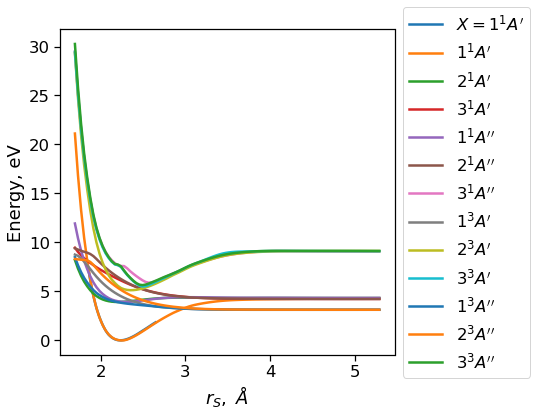

Plot 1D cuts along theta coordinate


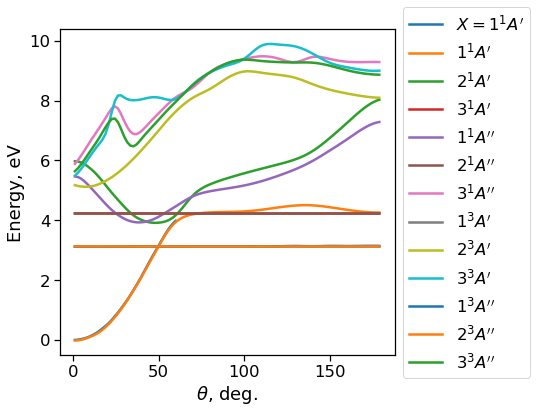

Plot 2D section along Jacobi (r_S, theta) coordinates


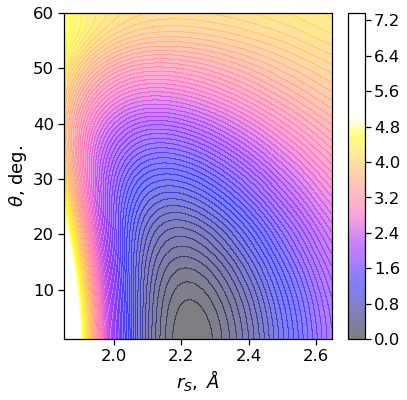

Plot 2D section along valence-bond (r_CS, alpha) coordinates


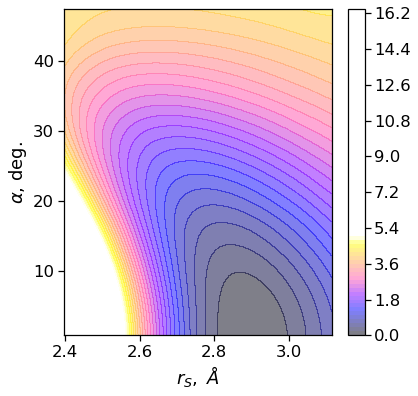

In [2]:
from numpy.polynomial.legendre import leggauss, legval, legder
from numpy.polynomial.laguerre import laggauss, lagval, lagder
from numpy.polynomial.hermite import hermgauss, hermval, hermder
import numpy as np
import math
from scipy import constants
import itertools
from typing import Optional, Tuple

from kinetic import Gmat, Gmat_batch
from ocs_coordinates import jacobi_to_cartesian
from ocs_potential import potentials

import jax
from jax import numpy as jnp
from jax import config

config.update("jax_enable_x64", True)

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Matplotlib settings
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (8, 6)

# Physics units conversion factors
hartree_to_invcm = constants.value('hartree-inverse meter relationship') / 100

## One-dimensional basis functions and Gaussian quadratures

- Orthogonal polynomials ([Wiki page](https://en.wikipedia.org/wiki/Orthogonal_polynomials)):
$$\int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}$$

- Examples of classical orthogonal polynomials:

    |Weight function $W(x)$ | Polynomial $P$ | Ranges |
    |:-:|:-:|:-:|
    |$e^{-x^2}$| Hermite | $[-\infty,\infty]$|
    | 1| Legendre | $[-1, 1]$|
    |$e^{-x}$ | Laguerre | $[0, \infty]$ |
    |$\sqrt{1-x^2}$ | Chebyshev | $[-1, 1]$|
    |$(1-x)^\alpha(1+x)^\beta,~\alpha,\beta>-1$| Jacobi | $[-1, 1]$|

- Build basis functions from orthogonal polynomials:
$$\phi_j(x) = \sqrt{W(x)}P_j(x),$$

$$\langle \phi_i|\phi_j\rangle = \int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}.$$

- Gaussian quadratures for integration ([Wiki page](https://en.wikipedia.org/wiki/Gaussian_quadrature)):

$$\int W(x)f(P(x))dx=\sum_g^{N_g} w_g f(x_g),$$

$$\langle \phi_i|V|\phi_j\rangle = \int W(x)\underbrace{P_i(x)P_j(x)V(x)}_{f(P(x))}dx\approx \sum_g^{N_g} w_g P_i(x_g)P_j(x_g)V(x_g)= \sum_g^{N_g} \frac{w_g}{W(x_g)} \phi_i(x_g)\phi_j(x_g)V(x_g).$$

Here are several examples of classical polynomials (Legendre, Laguerre, Hermite), that we will use as basis functions for the $r_\text{S}$, $r_\text{CO}$, and $\theta$ vibrational Jacobi coordinates.

In [4]:
def legendre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, c)


def legendre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivates of Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, legder(c, m=1))


def hermite(nmax: int, x: np.ndarray) -> np.ndarray:
    """Hermite functions, shape = (nmax, len(x))"""
    sqsqpi = np.sqrt(np.sqrt(np.pi))
    c = np.diag(
        [1.0 / np.sqrt(2.0**n * math.factorial(n)) / sqsqpi for n in range(nmax)]
    )
    return hermval(x, c) * np.exp(-(x**2) / 2)


def hermite_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivatives of Hermite functions, shape = (nmax, len(x))"""
    sqsqpi = np.sqrt(np.sqrt(np.pi))
    c = np.diag(
        [1.0 / np.sqrt(2.0**n * math.factorial(n)) / sqsqpi for n in range(nmax)]
    )
    H = hermval(x, c)
    dH = hermval(x, hermder(c, m=1))
    return (dH - H * x) * np.exp(-(x**2) / 2)


def laguerre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    return lagval(x, c) * np.sqrt(x) * np.exp(-x / 2)


def laguerre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivatives of Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    L = lagval(x, c)
    dL = lagval(x, lagder(c, m=1))
    return (2 * x * dL + (1 - x) * L) / (2 * x) * np.exp(-x / 2)

Let's generate quadratures and basis functions that are appropriate for the stretching $r_\text{S}$ and $r_\text{CO}$ and bending $\theta$ vibrational Jacobi coordinates

<img src="assets/images/ocs_jacobi.png" alt="Alternative text" width="200" />

and plot them.
Also, for testing, compute overlap integrals:

$$\int \phi_{i'}(x)\phi_{i}(x)dx\approx \sum_g \frac{w_g}{W(x_g)}\phi_{i'}(x_g)\phi_{i}(x_g)$$

Hermite quadrature 60 and basis 40 for coordinate 1
check orthonormality, max(|S-I|): 3.9968028886505635e-15
Hermite quadrature 60 and basis 40 for coordinate 2
check orthonormality, max(|S-I|): 3.9968028886505635e-15
Legendre quadrature 60 and basis 40 for coordinate 3
check orthonormality, max(|S-I|): 4.0745185003743245e-14


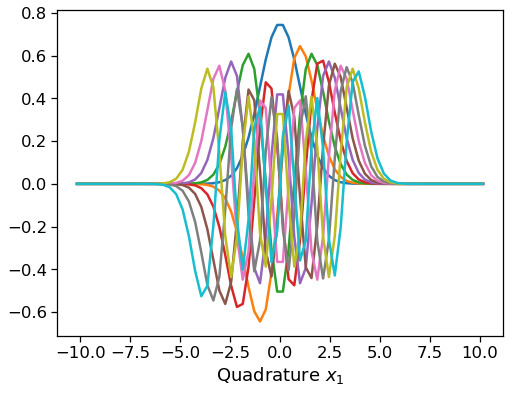

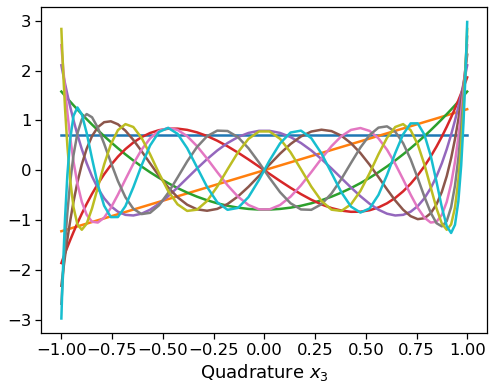

In [5]:
# number of basis functions for different coordinates
no_basis1 = 40
no_basis2 = 40
no_basis3 = 40

# number of Gaussian quadrature points for different coordinates
no_points1 = 60
no_points2 = 60
no_points3 = 60

# Hermite quadrature and functions for r_S coordinate
print(f"Hermite quadrature {no_points1} and basis {no_basis1} for coordinate 1")
x1, w1 = hermgauss(no_points1)
w1 /= np.exp(-x1**2)
psi1 = hermite(no_basis1, x1)

ovlp = np.einsum("ig,jg,g->ij", psi1, psi1, w1)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis1))))


# Hermite quadrature and functions for r_{CO} coordinate
print(f"Hermite quadrature {no_points2} and basis {no_basis2} for coordinate 2")
x2, w2 = hermgauss(no_points2)
w2 /= np.exp(-x2**2)
psi2 = hermite(no_basis2, x2)

ovlp = np.einsum("ig,jg,g->ij", psi2, psi2, w2)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis2))))


# Legendre quadrature/functions for theta coordinate
print(f"Legendre quadrature {no_points3} and basis {no_basis3} for coordinate 3")
x3, w3 = leggauss(no_points3)
psi3 = legendre(no_basis3, x3)

ovlp = np.einsum("ig,jg,g->ij", psi3, psi3, w3)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis3))))

# plot basis functions

plt.plot(x1, psi1[:10].T)
# plt.xlim([0, 100])
plt.xlabel("Quadrature $x_1$")
plt.show()

plt.plot(x3, psi3[:10].T)
plt.xlabel("Quadrature $x_3$")
plt.show()

We can now define 1D basis functions for different coordinates and their derivatives,
e.g., `func_psi1(x1)` $\rightarrow \phi_i^{(1)}(x_1)$, `func_dpsi1(x1)` $\rightarrow d\phi_i^{(1)}(x_1)/dx_1$.

In [6]:
func_psi1 = lambda x: hermite(no_basis1, x)
func_psi2 = lambda x: hermite(no_basis2, x)
func_psi3 = lambda x: legendre(no_basis3, x)

func_dpsi1 = lambda x: hermite_deriv(no_basis1, x)
func_dpsi2 = lambda x: hermite_deriv(no_basis2, x)
func_dpsi3 = lambda x: legendre_deriv(no_basis3, x)

# check that functions work, e.g., check orthonormality
ovlp = np.einsum('ig,jg,g->ij', func_psi1(x1), func_psi1(x1), w1)
print("check orthonormality for coo 1, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis1))))

check orthonormality for coo 1, max(|S-I|): 3.9968028886505635e-15


## Map physical coordinates into quadrature points

You may have noticed that the ranges for the quadrature coordinates $x_1$, $x_2$, and $x_3$ dont' align well with the physical coordinate ranges for $r_\text{S}$, $r_\text{CO}$, and $\theta$.

For example, print min and max values of quadrature coordinates and compare them with min and max values of Jacobi coordinates used to represent the PES for the ground electronic state of OCS.

In [7]:
xmin = np.min([x1, x2, x3], axis=-1)
xmax = np.max([x1, x2, x3], axis=-1)

rmin = potentials[0].min
rmax = potentials[0].max

for icoo in range(3):
    print(f"\nx{icoo}: [{xmin[icoo].round(4)}, {xmax[icoo].round(4)}]")
    print(f"r{icoo}: [{rmin[icoo].round(4)}, {rmax[icoo].round(4)}]")


x0: [-10.1591, 10.1591]
r0: [1.8521, 2.6459]

x1: [-10.1591, 10.1591]
r1: [0.9525, 1.3759]

x2: [-0.9992, 0.9992]
r2: [0.0175, 1.0472]


Therefore, it's essential to apply a transformation $f_{x\rightarrow r}$ that maps the physical coordinates' range accurately onto the quadrature grids.

- For the Hermite basis functions, we know that they are used to represent solutions of the quantum harminic oscillator problem, with the Hamiltonian
  $$ \hat{H} = -\frac{1}{2}\left(\frac{1}{m}\right)\nabla_r^2 + \frac{1}{2}m\omega r^2.$$
  and solutions ([Wiki page](https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator))
  $$ \psi_n(r) = \sqrt{\frac{1}{2^nn!\sqrt{\pi}}} (m\omega)^{1/4} e^{-m\omega r^2/2} H_n(\sqrt{m\omega}r), $$
  which can be written in terms of Gauss-Hermite quadrature coordinate $x$ if 
  $$x = \sqrt{m\omega}r = \alpha r.$$

- By comparing our vibrational Hamiltonian with harmonic oscillator, obtain
  $$ \hat{H} = -\frac{1}{2}G \nabla_r^2 + V~~~\rightarrow~~~m=1/G,~m\omega^2 = \frac{\partial^2 V}{\partial r^2},~\frac{\partial V}{\partial r}=0, $$
  from which we can derive the coordiante mapping constant $\alpha$ as
  $$\alpha=\sqrt{m\omega}=\sqrt{\sqrt{\frac{\partial^2V}{\partial r^2}\frac{1}{G}}}.$$

- Further, we whant to map the center of the quadrature $x$ (placed at zero) to the equilibrium value of physical coordinate (at $r_\text{eq}$):
  $$x = \alpha (r-r_\text{eq}).$$

- For the Legendre basis functions, we can map the quadrature range $[-1,1]$ into the range $[0,\pi]$ for the angular coordiante $\theta$ as
  $$x=\cos(\theta).$$

The coordiante mapping $f_{x\rightarrow r}$ is implemented in function `map_x_to_r` (and its vectorised version `map_x_to_r_batch`),
and the Jacobial of the cooridnate transformation $\nabla_x f_{x\rightarrow r}$ is implemented in function `jac_x_to_r`.

<!-- Note also that when changing cooridnates from physical $(r_\text{S},r_\text{CO},\theta)$ to quadrature $(x_1,x_2,x_3)$, -->
<!-- the corresponding integration volume element $dr_\text{S}dr_\text{CO}d\theta$ -->
<!-- will also change to $\left|\det{\nabla_x f_{x\rightarrow r}(x_1,x_2,x_3)}\right|dx_1dx_2dx_3$. -->

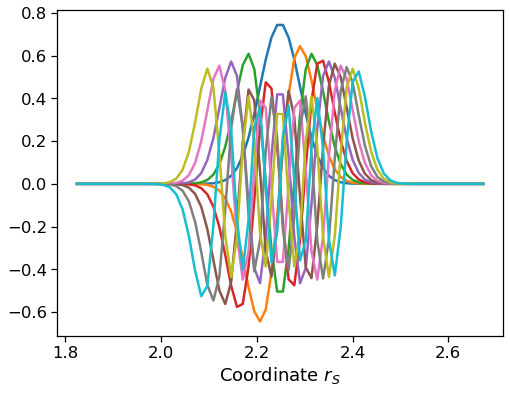

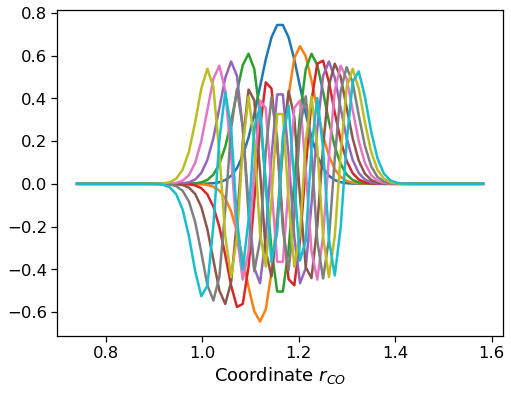

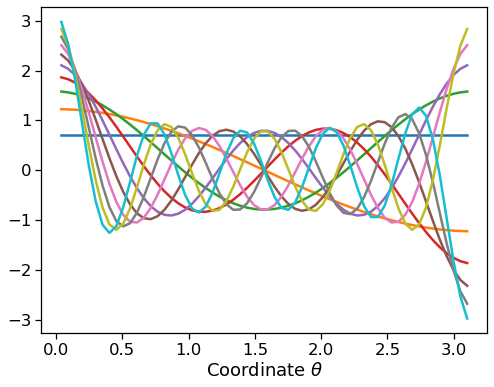

In [8]:
# serial version of mapping function
def map_x_to_r(x, r_eq, poten_deriv2, gmat_diag):
    alpha = jnp.sqrt(jnp.sqrt(2 * poten_deriv2 / gmat_diag))
    return jnp.array(
        [
            x[0] / alpha[0] + r_eq[0],
            x[1] / alpha[1] + r_eq[1],
            jnp.arccos(x[2]),
        ]
    )


# vectorised version of `x_to_r`
map_x_to_r_batch = jax.jit(jax.vmap(map_x_to_r, in_axes=(0, None, None, None)))

# jacobian of the x -> r transformation, dr/dx
jac_x_to_r = jax.vmap(jax.jacrev(map_x_to_r, argnums=0), in_axes=(0, None, None, None))

# PES equilibrium
r_eq = potentials[1].eq

# PES second-order derivative for each coordinate at equilibrium
poten_deriv2 = potentials[1].deriv2 * hartree_to_invcm

# diagonal elements of G matrix
gmat_diag = np.diag(Gmat(r_eq, jacobi_to_cartesian)[:3,:3])

# compute physical coordiantes from quadratures
r1, r2, r3 = map_x_to_r([x1, x2, x3], r_eq, poten_deriv2, gmat_diag)

# plot basis functions

plt.plot(r1, psi1[:10].T)
plt.xlabel("Coordinate $r_S$")
plt.show()

plt.plot(r2, psi2[:10].T)
plt.xlabel("Coordinate $r_{CO}$")
plt.show()

plt.plot(r3, psi3[:10].T)
plt.xlabel("Coordinate $\\theta$")
plt.show()

## Build direct-product basis set and matrix elements

- Our task is to compute matrix elements (integrals), like, for example, of the potential energy operator:
  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dr_\text{S}dr_\text{CO}dr_\theta,
  $$
  
  which can be approximated using Gaussian quadratures for each vibrational coordinate, as
  $$V_{l',l}\approx
  \sum_f^{N_f} \sum_g^{N_g}\sum_h^{N_h}w_f^{(1)}w_g^{(2)}w_h^{(3)}
  \phi_{i'}^{(1*)}(x_f^{(1)})\phi_{j'}^{(2*)}(x_g^{(2)})\phi_{k'}^{(3*)}(x_h^{(3)})
  V\left(r_S(x_f^{(1)}),r_{CO}(x_g^{(2)}),\theta(x_h^{(3)})\right)
  \phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)}).
  $$
- Introduce a multi-index for combinations of quantum numbers $l=\{i,j,k\}$, $l'=\{i',j',k'\}$ and quadrature points $p=\{f,g,h\}$, such that
  $$x_p=(x_f^{(1)},x_g^{(2)}, x_h^{(3)}),$$
  $$w_p = w_f^{(1)}w_g^{(2)}w_h^{(3)},$$
  $$\Phi_l(x_p)=\phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)}).$$

- The matrix elements of potential can now be expressed in a compact form
  $$V_{l',l}=\sum_p w_p \Phi_{l'}^*(x_p)V(f_{x\rightarrow r}(x_p)) \Phi_l(x_p).
  $$

- A similar compact expression for the matrix elements of kinetic energy operator can be obtained as
  $$
  T_{l',l}=-\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
  \Phi_{l'}^*(x_p)\frac{\partial}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial}{\partial r_\mu} \Phi_l(x_p) = \\
  =\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
  \frac{\partial\Phi_{l'}^*(x_p)}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu},
  $$
  
  where $r_\lambda, r_\mu \in \{r_\text{S}, r_\text{CO}, \theta\}$ and
  $$
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu} =
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\frac{\partial x_p}{\partial r_\mu} = 
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\frac{\partial x_\mu}{\partial x_p}\right)^{-1} = 
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\nabla_x f_{x\rightarrow r}\right)^{-1}
  $$

------

First, compute multi-index for quantum numbers $l=\{i,j,k\}$, where $i, j, k$ range from 0 to 30. Define $l=i\otimes j\otimes k$ subject to the constraint $w_1i+w_2j+w_3k\leq L_\text{max}$.
The truncation parameter $L_\text{max}$ determines the number of basis functions included; a larger $L_\text{max}$ results in a greater number of basis functions.
The weights $w_1$, $w_2$, $w_3$ can be used to adjust the relative number of basis functions for specific coordinates within the product basis.

For example, in OCS, the energies of the stretching modes are approximately twice as strong as the energy of the bending mode.
Therefore, it makes sense to double the number of bending basis functions in the product basis to achieve a balanced description.

Additionally, it makes sense to increase the number of basis functions for those coordinates where the basis set is not good.

In [9]:
quanta1 = np.arange(0, no_basis1)
quanta2 = np.arange(0, no_basis2)
quanta3 = np.arange(0, no_basis3)
l_max = 20
weights_ijk = np.array([2, 2, 1])  # w1, w2, and w3 coefs for r_S, r_CO, and theta

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_ijk) <= l_max
    ]
)  # shape = (no. basis funcs, 3)

print(quanta)
print("total number of basis functions:", len(quanta))

[[ 0  0  0]
 [ 0  0  1]
 [ 0  0  2]
 ...
 [ 9  0  2]
 [ 9  1  0]
 [10  0  0]]
total number of basis functions: 506


Next, compute product-quadrature grid for multi-variate integration $x_p=(x_f^{(1)},x_g^{(2)}, x_h^{(3)})$ and $w_p = w_f^{(1)}w_g^{(2)}w_h^{(3)}$.

Also, compute values of physical coordinates $r_\text{S}$, $r_\text{CO}$, and $\theta$ on product-quadrature grid using the mapping function `map_x_to_r_batch` defined earlier.

In [10]:
# direct product quadrature grid
x_points = np.stack(
    [elem.ravel() for elem in np.meshgrid(x1, x2, x3)], axis=-1
)  # shape = (no. quad. points, 3)

# direct product of quadrature weights
weights = np.prod(np.stack(
    [elem.ravel() for elem in np.meshgrid(w1, w2, w3)], axis=-1
), axis=-1)

print("total number of quadrature points:", len(x_points))

# values of physical coordinates on quadrature grid
r_points = map_x_to_r_batch(x_points, r_eq, poten_deriv2, gmat_diag)

print("Min values of r_S, r_CO, and theta:", np.min(r_points, axis=0))
print("Max values of r_S, r_CO, and theta:", np.max(r_points, axis=0))

total number of quadrature points: 216000
Min values of r_S, r_CO, and theta: [1.82470787 0.74046836 0.03974873]
Max values of r_S, r_CO, and theta: [2.67236141 1.58219273 3.10184392]


Compute operators on the product grid, kinetic energy matrix $G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))$, $(\lambda,\mu=1..3N-6)$, and potential $V(f_{x\rightarrow r}(x_p))$ (for one or several electronic states).

Also, compute Jacobian of the coordinate transformation $\left(\nabla_x f_{x\rightarrow r}\right)^{-1}$, necessary for building the kinetic energy operator.

In [11]:
# evaluate kinetic-energy matrix (in cm^-1)
G = Gmat_batch(r_points, jacobi_to_cartesian)
G = G[:, :3, :3]  # select only vibrational part

# potentials for ground and excited states (in cm^-1)
ind_elec0 = 1
ind_elec1 = 2
V0 = (potentials[ind_elec0].pes(r_points) - potentials[ind_elec0].e0) * hartree_to_invcm
V1 = (potentials[ind_elec1].pes(r_points) - potentials[ind_elec1].e0) * hartree_to_invcm

# evaluate Jacobian of coordinate transformation
jac = jac_x_to_r(x_points, r_eq, poten_deriv2, gmat_diag)
jac_inv = np.linalg.inv(jac)

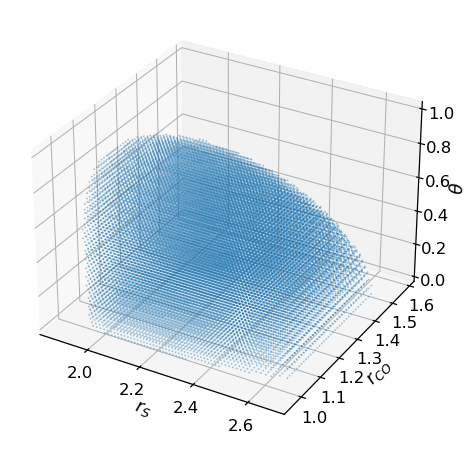

In [12]:
# plot grid points corresponding to the potential values lower than certain threshold
ind = np.where(V0 < 30000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(*r_points[ind].T, s=1, alpha=0.3)
ax.set_xlabel("$r_{S}$")
ax.set_ylabel("$r_{CO}$")
ax.set_zlabel("$\\theta$")
plt.show()

The remaining quantities are products of basis functions $\Phi_l(x_p)=\phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)})$ and derivatives $\partial\Phi_l(x_p)/\partial x_p.$

For this, we use `func_psi1`, `func_psi2`, and `func_psi3` as well as `func_dpsi1`, `func_dpsi2`, and `func_dpsi3` functions defined earlier.

In [13]:
x1_, x2_, x3_ = x_points.T
q1, q2, q3 = quanta.T

psi = func_psi1(x1_)[q1] * func_psi2(x2_)[q2] * func_psi3(x3_)[q3]

dpsi = np.array(
    [
        func_dpsi1(x1_)[q1] * func_psi2(x2_)[q2] * func_psi3(x3_)[q3],
        func_psi1(x1_)[q1] * func_dpsi2(x2_)[q2] * func_psi3(x3_)[q3],
        func_psi1(x1_)[q1] * func_psi2(x2_)[q2] * func_dpsi3(x3_)[q3],
    ]
)

Now that all components have been precomputed, construct the matrix elements for both the potential and kinetic energy operators.

$$ V_{l',l}=\sum_p w_p \Phi_{l'}^*(x_p)V(f_{x\rightarrow r}(x_p)) \Phi_l(x_p),$$

$$
\frac{\partial\Phi_l(x_p)}{\partial r_\mu} =
\frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\nabla_x f_{x\rightarrow r}\right)^{-1},
$$

and

$$
T_{l',l}=\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
\frac{\partial\Phi_{l'}^*(x_p)}{\partial r_\lambda}
G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
\frac{\partial\Phi_l(x_p)}{\partial r_\mu}.
$$

In [14]:
pot0 = np.einsum("lp,mp,p,p->lm", psi, psi, V0, weights, optimize="optimal")
pot1 = np.einsum("lp,mp,p,p->lm", psi, psi, V1, weights, optimize="optimal")

dpsi_ = np.einsum("xlp,pxr->rlp", dpsi, jac_inv, optimize="optimal")
keo = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi_, dpsi_, G, weights, optimize="optimal")

Diagonalise Hamiltonian matrix for different electronic states

In [15]:
h0 = keo + pot0
e0, v0 = np.linalg.eigh(h0)

h1 = keo + pot1
e1, v1 = np.linalg.eigh(h1)

Print state energies and state assignments

In [16]:
no_states = 20
for e, v, i in zip(e0, v0.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e0[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.08703846823681859 [0 0 7]
1 939.9348763667008 0.08913125577210365 [1 0 6]
2 1806.1575208361355 0.0777331106704933 [ 0  0 14]
3 1955.0482698751593 0.07256342226578322 [2 0 6]
4 2128.0231420708533 0.08580872488203532 [0 1 6]
5 2912.9119678081834 0.08183739572354345 [3 0 5]
6 3101.4284383446548 0.07969105995043656 [1 1 5]
7 3259.0983898908053 0.07315240151082064 [1 0 3]
8 4056.0406736787327 0.09764231458895897 [4 0 4]
9 4144.374069053355 0.07196642034742783 [2 1 5]
10 4231.191404571102 0.05870667343843526 [0 2 5]
11 4416.611691966859 0.06535297756215479 [0 1 3]
12 4738.418246089253 0.08438739850469691 [2 0 2]
13 5201.035373335498 0.0770123659030784 [0 0 9]
14 5301.159515791553 0.09142052921497577 [3 1 4]
15 5345.155542152604 0.08236018360710191 [1 2 5]
16 5374.938008600499 0.10283206543362074 [5 0 3]
17 5920.203322035596 0.08504400406949601 [1 1 2]
18 6456.177247717269 0.08582417443401623 [3 0 2]
19 6489.119370198825 0.0738839806792405 [0 3 4]


In [17]:
no_states = 20
for e, v, i in zip(e1, v1.T, range(no_states)):
    ind = np.argmax(np.abs(v))
    print(i, e - e1[0], np.abs(v[ind]) ** 2, quanta[ind])

0 0.0 0.13195118734461417 [0 0 1]
1 476.41377790721685 0.11258768596776297 [1 0 1]
2 833.0255085905476 0.14209903968682286 [ 0  0 10]
3 1014.123317370889 0.09027274066718514 [2 0 1]
4 1435.4136955522815 0.11500238444922853 [ 1  0 10]
5 1728.2261704142145 0.07528378337290242 [3 0 1]
6 1797.1296403949366 0.11387108133832277 [ 0  0 12]
7 1951.460718464699 0.09651278051778303 [0 1 4]
8 2306.73933549662 0.09703178849643537 [2 0 6]
9 2445.846646959799 0.10516977698734446 [1 1 1]
10 2583.1938831651205 0.07292065019276081 [6 0 1]
11 2846.2630648439417 0.07133348415702097 [ 0  1 10]
12 2874.0386058036083 0.07688109791704216 [ 1  0 12]
13 3125.6696984553546 0.1029429834427178 [2 1 1]
14 3227.9810023166665 0.09967207122725794 [3 0 6]
15 3367.4302456799433 0.0900503815755326 [ 0  0 14]
16 3593.3084814030926 0.07872419223071841 [5 0 1]
17 3688.961763657051 0.10516556041495065 [1 1 6]
18 3845.7964753655506 0.07185817825442081 [0 2 1]
19 3910.8337975503227 0.03935761291202704 [3 1 1]


## Contracted basis for bending coordinate

The Legendre basis set for the bending coordinate converges very slowly, primarily due to the range $[0,\pi]$
selected for the $\theta$ coordinate. The reason for this broad range for the angular coordinate is that
the potentials for different electronic excited states of OCS have minima at markedly different values
of the $\theta$ angle (see [ocs_potential.ipynb](ocs_potential.ipynb)).
To accommodate both states, the range for the $\theta$ angle must be broad.

The basis for the $\theta$ angle can be improved, for example, if instead of Legendre functions we choose
eigenfunctions of pure bending Hamiltonian, that is
$$ \Phi_l^{(3)} = \sum_{k} c_{k}^{(l)}\phi_0^{(1)}(x_1)\phi_0^{(2)}(x_2)\phi_k^{(3)}(x_3),$$
$$(\hat{T}+V)\Phi_l^{(3)} = E_l\Phi_l^{(3)}.$$

In [18]:
# freeze quantum numbers for stretches to 0
quanta1 = [0]
quanta2 = [0]
quanta3 = np.arange(0, no_basis3)
l_max = 40
weights_ijk = np.array([1, 1, 1])

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_ijk) <= l_max
    ]
)  # shape = (no. basis funcs, 3)

# compute function and derivatives
x1_, x2_, x3_ = x_points.T
q1, q2, q3 = quanta.T

# compute product basis and derivatives
psi = func_psi1(x1_)[q1] * func_psi2(x2_)[q2] * func_psi3(x3_)[q3]
dpsi = np.array(
    [
        func_dpsi1(x1_)[q1] * func_psi2(x2_)[q2] * func_psi3(x3_)[q3],
        func_psi1(x1_)[q1] * func_dpsi2(x2_)[q2] * func_psi3(x3_)[q3],
        func_psi1(x1_)[q1] * func_psi2(x2_)[q2] * func_dpsi3(x3_)[q3],
    ]
)

# compute matrix elements of potential and kinetic energy operators
pot0 = np.einsum("lp,mp,p,p->lm", psi, psi, V0, weights, optimize="optimal")
pot1 = np.einsum("lp,mp,p,p->lm", psi, psi, V1, weights, optimize="optimal")
dpsi_ = np.einsum("xlp,pxr->rlp", dpsi, jac_inv, optimize="optimal")
keo = 0.5 * np.einsum("rlp,smp,prs,p->lm", dpsi_, dpsi_, G, weights, optimize="optimal")

# diagonalise Hamiltonian for two electronic states
h0 = keo + pot0
e0, v0_contracted_coo_3 = np.linalg.eigh(h0)
h1 = keo + pot1
e1, v1_contracted_coo_3 = np.linalg.eigh(h1)

# redefine basis functions and derivatives for coordinate theta
# now, this function will depend on the electronic state

func_psi3_el0 = lambda x: np.dot(v0_contracted_coo_3.T, legendre(no_basis3, x))
func_dpsi3_el0 = lambda x: np.dot(v0_contracted_coo_3.T, legendre_deriv(no_basis3, x))

func_psi3_el1 = lambda x: np.dot(v1_contracted_coo_3.T, legendre(no_basis3, x))
func_dpsi3_el1 = lambda x: np.dot(v1_contracted_coo_3.T, legendre_deriv(no_basis3, x))

## Compute Franck-Condon transitions

Here, we will calculate the transitions between the vibrational states corresponding to different electronic states,
using Franck-Condon approximation ([Wiki page](https://en.wikipedia.org/wiki/Franck%E2%80%93Condon_principle))
$$ S(k',i'\leftarrow k,i)= \left|\langle \Psi_{k'}^{(i')}| \mu(i'\leftarrow i)|\Psi_{k}^{(i)}\rangle\right|^2\approx \left|\langle \Psi_{k'}^{(i')}|\Psi_{k}^{(i)}\rangle\right|^2.$$

In [20]:
# transform basis functions to the eigenfunction representation, i.e. solutions of vib. Schrödinger equation
psi0 = np.dot(v0.T, psi)
psi1 = np.dot(v1.T, psi)

# overlap between vibrational wavefunctions of diff. states
overlap = np.einsum("lp,kp,p->lk", psi0, psi1, weights, optimize="optimal")

# vibrational transition frequencies between diff. elec. states
elec_shift = (potentials[ind_elec1].e0 - potentials[ind_elec0].e0) * hartree_to_invcm
freq = np.abs(e0[:, None] - (e1[None, :] + elec_shift))

# energies of initial transition states
enr_ini = e0[:, None] * np.ones_like(e1)[None, :]

# indices of upper triangular part
ind = np.triu_indices(n=len(psi0), k=1, m=len(psi1))

# transition strengths, freqs., and ini-state energies
tran_str = np.abs(overlap[ind]) ** 2
freq = freq[ind]
enr_ini = enr_ini[ind]

Plot stick spectrum

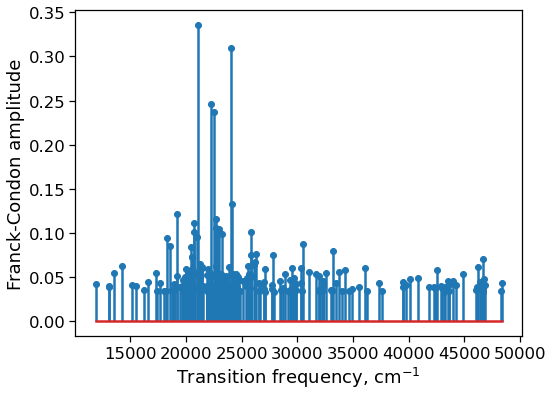

In [21]:
ind = np.where(tran_str >= np.max(tran_str) / 10)
plt.stem(freq[ind], tran_str[ind])
plt.xlabel("Transition frequency, cm$^{-1}$")
plt.ylabel("Franck-Condon amplitude")
plt.show()

Convolute with Lorentz profile

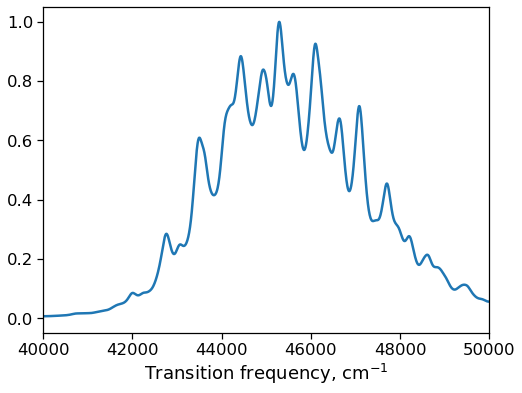

In [22]:
width = 250
temp = 170.0
kB = constants.value("Boltzmann constant in inverse meter per kelvin") / 100
Boltz = np.exp(-enr_ini / (kB * temp))
Boltz = Boltz / np.sum(Boltz)
points = np.linspace(np.min(freq), np.max(freq), 10000)


def convolute_lorentz(points, x, y, width):
    f = np.zeros(len(points))
    for i in range(len(x)):
        f += y[i] * 1 / np.pi * 0.5 * width / ((points - x[i]) ** 2 + 0.25 * width**2)
    return f


crossec = convolute_lorentz(points, freq, tran_str * Boltz, width)

plt.plot(points, crossec / np.max(crossec))
plt.xlabel("Transition frequency, cm$^{-1}$")
plt.xlim([40000, 50000])
plt.show()